# Проект 3. О вкусной и здоровой пище

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- __Restaurant_id__ — идентификационный номер ресторана / сети ресторанов;


- __City__ — город, в котором находится ресторан;


- __Cuisine Style__ — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;


- __Ranking__ — место, которое занимает данный ресторан среди всех ресторанов своего города;


- __Rating__ — рейтинг ресторана по данным TripAdvisor (__целевая переменная (!)__);


- __Price Range__ — диапазон цен в ресторане;


- __Number of Reviews__ — количество отзывов о ресторане;


- __Reviews__ — данные о двух отзывах, которые отображаются на сайте ресторана;


- __URL_TA__ — URL страницы ресторана на TripAdvisor;


- __ID_TA__ — идентификатор ресторана в базе данных TripAdvisor.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from math import cos
from math import sin
from statistics import mode
import re
import requests    # библиотека для сохранения Web-страницы из Интернет
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
# зафиксируем random seed
RANDOM_SEED = 42

In [3]:
# используемые функции и классы

class CheckByPattern():
    '''
        Класс для проверки значений в столбце датафрейма с использованием
        шаблона из регулярных выражений
    '''

    def __init__(self):
        self.match = []
        self.not_match = []

    def my_pattern(self, pattern):
        self.pattern = re.compile(pattern)

    def my_string(self, string):
        if sel.pattern.match(string) is not None:
            return 'Matched'
        else:
            return 'Not matched'

    def my_series(self, series):
        self.series = series
        for value in self.series:
            if self.pattern.match(value) is not None:
                self.match.append(value)
            else:
                self.not_match.append(value)

        self.result = f"В столбце {series.name}:\n\
        - Совпадает с шаблоном: {len(self.match)} записей;\n\
        - Не совпадает: {len(self.not_match)} записей."

        return print(self.result)


def convert_to_list(str_data):
    '''
        Функция исправляет признак Reviews, конвертируюя записи в списки.
        Также учтены двойные кавычки в строке 177 и слово nan в строке 5315.
    '''
    nan_reviews = [['a', 'a'], ['01/01/1900', '01/01/1900']]
    if pd.isna(str_data):
        return nan_reviews
    str_data = str_data.replace('"', "'")  # строка 177
    str_data = str_data.replace('nan', "'nan'")  # строка 5315
    str_data = str_data[3:-3]
    list_data = str_data.split("'], ['")
    list_data[0] = list_data[0].split("', '")
    list_data[1] = list_data[1].split("', '")
    return list_data


def fill_nans(feature, dataframe, by='city', using='mode'):
    '''
       Функция для заполнения пропусков в датафрейме, где:
       feature   - признак, в котором будем заполнять пропуски;
       dataframe - датафрейм, с которым будем работать;
       by        - признак по коотрому будет группировка ('City' по-умолчанию);
       using     - используемый метод (мода (по-умолчанию), среднее, медиана).
    '''
    process = dataframe[[feature, by]].groupby([by])
    if using == 'mode':
        grouped = process.agg(lambda x: x.value_counts().index[0])
    elif using == 'mean':
        grouped = process.mean().round()
    elif using == 'median':
        grouped = process.median()
    else:
        grouped = process.agg(lambda x: x.value_counts().index[0])
    # результат группировки запишем в словарь, где:
    # ключ - название города
    # значение - медиана количества обзоров
    grouped = grouped.to_dict()
    grouped = grouped.get(feature)
    # отфильтруем df по признаку fearture, значения
    # для которого пустые
    number_nans = dataframe[pd.isna(dataframe[feature])]
    # создадим series с пустыми данными в признаке feature
    number_nans = number_nans[feature]

    for idx in number_nans.index:
        key = dataframe.at[idx, by]
        dataframe.at[idx, feature] = grouped.get(key)


In [4]:
# функции для визуализации


def df_info(dataframe):
    '''
        Функция вывода информации по датасету (dataframe):
        - чисдо записей
        - число столбцов.
    '''
    print(f'Всего записей в датасете: {len(dataframe)}')
    print(f'Всего столбцов: {len(dataframe.columns)}')


def data_quality(dataframe, col, types='any'):
    '''
        Функция вывода абсолютного и относительного количества
        пропущенных значений для столбца col из df, а также какие
        уникальные значения у нас есть и их количество
    '''
    # подсчитаем число пропущенных значений
    nan_entrys = dataframe[col].isnull().sum()
    # сформируем данные по значениям, которые у нас есть
    if types == 'any':            # для любых типов данных, кроме списков
        data = dataframe[col].value_counts()
    elif types == 'list':         # для списков
        data = dataframe[col].explode().value_counts()
    # выведем количество пропущенных значений
    return (print('Для показателя', col, 'количество пропущенных значений:',
                  nan_entrys, 'из', len(dataframe), '\nВ пустых значениях',
                  round(nan_entrys/len(dataframe)*100, 1), '% записей.',
                  '\nКоличество уникальных значений:',
                  len(data)),'\n\n',
                  display(data));


def count_plot(dataframe, col, size=(5, 5), rotx=0):
    '''
        Функция вывода графика для столбца col типа Seaborn.countplot, где
        col - столбец из df;
        size - размер области графика;
        rotx - угол поворота подписей для оси x
    '''
    plt.figure(figsize=size)     # размер области графика
    sns.set(style='darkgrid',    # стиль фона графиков в seaborn
            font_scale=1.2)      # размер шрифта для лучшей читаемости
    plot = sns.countplot(data=dataframe, x=col)   # объект с графиком
    for xlabel in plot.get_xticklabels():  # цикл с метками на оси x
        xlabel.set_rotation(rotx)          # поворот меток на угол rotx
    return plot.set_title(col, size=20)


def box_plot(colx, coly, size=(5, 5), rotx=0):
    '''
        Функция вывода  графика Seaborn.boxplot, отображающего распределение
        значений столбца по отношению к целевому признаку, где
        colx - название анализируемого столбца из df,
        coly - столбец с целевым признаком из df,
        size - размер области графика,
        rotx - угол поворота подписей для оси x '''
    plt.figure(figsize=size)       # размер области графика
    sns.set(style='darkgrid',      # стиль фона графиков в seaborn
            font_scale=1.2)        # размер шрифта для лучшей читаемости
    plot = sns.boxplot(data=df,    # объект с графиком
                       x=colx,
                       y=coly,
                       fliersize=8)
    for xlabel in plot.get_xticklabels():  # цикл с метками на оси x
        xlabel.set_rotation(rotx)          # поворот меток на угол rotx
    return plot.set_title(colx, size=20)


def display_data(dataframe, col, size=(5, 5), rotx=45):
    '''
        Вывод информации по признакам
    '''
    print('======================================',
          f'\n|  Данные для показателя {col}',
          '|\n======================================')
    data_quality(dataframe, col)
    count_plot(dataframe, col, size, rotx=45)


In [5]:
# функции в этом блоке кода не используются. Оставил их как пример проделанной
# работы по извлечению пропущенных данных с интернет-страниц ресторанов с
# применением признака URL_TA

def download_pages(dataframe):
    '''
        Функция загружает с сайта TripAdviso web-страницы с данными
        по ресторанам. Адреса страниц берутся из имеющегося датасета
    '''
    for index in dataframe.index:
        # имени файла присваивается значение признака id_ta
        file_name = dataframe.loc[index].id_ta
        # добавили адрес сайта TripAdvisor к адресу web-страницы ресторана
        # для корректной загрузки страниц
        url = 'https://www.tripadvisor.com' + dataframe.loc[index].url_ta
        r = requests.get(url)
        with open('web_pages/{}.html'.format(file_name),
                  'w', encoding='utf-8') as output_file:
            output_file.write(r.text)


def lines(local_file):
    '''
        Функция определяет строки в загруженном файле с
        сайта TripAdvisor для дальнейшего поиска признаков строке,
        которую мы укажем, например для признак Cusine style мы будем
        искать в последней строке в диапазоне  между 4000 и 8000
        (lines[-1][4000:8000])
    '''
    with open(local_file, "r", encoding="utf-8") as file:
        lines = file.readlines()
    return lines


def find_cuisine(string):
    '''
        Функция извлекает из строки признак 'cuisine' и формирует
        список со значениями
    '''
    if 'cuisine' not in string:
        return np.nan
    # ищем позицию, с которой начинается слово 'cuisine'
    idx = string.index('cuisine')
    # обрезаем строку с начала до слова 'cuisine'
    string = string[idx:]
    # ищем позицию, где стоят символы '],' - конец данных о cuisine
    idx = string.index('],')
    # обрезаем строку справа, все лишнее что после данных о cuisine
    string = string[:idx]
    # обрезаем лишнее в начале строки - 'cuisine":["' и в конце '"'
    # и переводим буквы в нижний регистр
    string = string[11:-1].lower()
    # создаём список с cuisine
    cuisine_list = string.split('","')
    return cuisine_list


def find_price_range(string):
    '''
        Функция извлекает из строки признак Price Range
    '''
    if 'priceRange' not in string:
        return np.nan
    # ищем позицию, с которой начинается слово 'priceRange'
    idx = string.index('priceRange')
    # обрезаем строку с начала до слова 'priceRange'
    string = string[idx:]
    # ищем позицию, где заканчиваеися строка с информацией о Price Range('",') 
    idx = string.index('",')
    # обрезаем строку справа, все лишнее что после данных о Price Range
    string = string[:idx]
    # обрезаем лишнее в начале строки - 'priceRange":"'
    string = string[13:]
    return string


Стоит отметить, что из данной работы убрана возможность заполнения некоторых пустых данных путем загрузки информации по ресторанам с сайта TripAdvisor (https://www.tripadvisor.com).

В ходе работы я присоединял к адресу сайта строку из url_ta, получая прямую ссылку на страницу ресторана.

При помощи __функции `download_pages`__ автоматически загружал __страницы ресторанов__ в формате _html_ в отдельную __папку `web_pages`__ для тех ресторанов, у которых нет записей по кухне и прайсу и качает html страницы в отдельную папку.

Далее при помощи функции `lines` определял __строки в html__ файле и уже при помощи функций `find_cuisine` и `find_price_range` искал необходимую информацию по кухне и ценовому диапазону соответственно.

Путём предварительного визуального осмотра __содержимого файла html__ было выявлено, что информация по __кухне__ содержится __в последний строке файла__, а по __ценовому диапазону - в первой строке файла__.


Полученная информация из файлов записывалась в соответствующие пустые поля датафрейма.

В моих условиях загрузка страниц ресторанов с сайта была со скоростью 24 страницы в минуту, всего пришлось качать  примерно 13000 страниц, что заняло 9 часов непрерывной работы кода.

В итоге таким способом удалось восстановить информацию примерно по 2500 ресторанам.

Ниже строки кода, описывающие обозначенные мной выше действия я отключил, так как не было полного понимания как выгрузить загруженные страницы в github, чтобы код был воспроизводим и чтобы преотвратить долгую проверку моего ноутбука преподавателем. В качестве альтернативы я заполнил пропуски при помощи функции `fill_nans`.

In [6]:
# код в этом блоке отключен
'''
    Заполнение пропусков в признаке Cuisine Style путём загрузки страниц
    ресторанов с сайта TripAdvisor
'''
# создадим копию датафрейма, в которой отсортированы строки с NaN в cuisine
# cuisine_nan = df[pd.isna(df['cuisine'])]

# загрузим страницы ресторанов для которых пустое значение в принаке стиль 
# кухни - Cuisine Style.
# скорость загрузки зависит от качества интернет.
# в моём случае скорость загрузки в среднем составляла 24 файла/мин.
# download_pages(cuisine_nan)

# создадим список files с именами файлов, которые мы загрузили.
# files = os.listdir(path="web_pages")
# обрежем имя файла, убрав расшерение '.html', так будет проще сопоставлять
# имя файла с признаком id_ta
# files = [file[:-5] for file in files]

# пройдемся по всем записям в отсортированном датафрейме, используя индексы
#for idx in cuisine_nan.index:
#    # если значение признака id_ta совпадает с именем файла в списке
#    if cuisine_nan.id_ta[idx] in files:
#        # формируем ссылку к файлу
#        local_file = 'web_pages/' + cuisine_nan.id_ta[idx] + '.html'
#        # используем функцию lines для поиска признака в последней строке файла
#        string = lines(local_file)[-1][3000:7000]
#        # используем функцию find_cuisine для извлечения признака в формате списка
#        cuisine_list = find_cuisine(string)
#        # перепишем пустое значение в датафрейме полученным результатом
#        df.at[idx, 'cuisine'] = cuisine_list


'\n    Заполнение пропусков в признаке Cuisine Style путём загрузки страниц\n    ресторанов с сайта TripAdvisor\n'

In [7]:
# код в этом блоке отключен
'''
    Заполнение пропусков в признаке Price Range путём загрузки страниц
    ресторанов с сайта TripAdvisor
'''

# создадим копию датафрейма, в которой отсортированы строки с NaN в price_range
# price_nan = df[pd.isna(df['price'])]
# price_nan.info()

# загрузим страницы
# download_pages(price_nan)
# в моих условиях скорость загрузки в среднем составляла 24 файла/мин.

# обновим список с загруженными файлами
# files = os.listdir(path="web_pages")
# обрежем имя файла, убрав расшерение '.html', так будет проще сопоставлять
# имя файла с признаком id_ta
# files = [file[:-5] for file in files]

# пройдемся по всем записям в отсортированном датафрейме, используя индексы
#for idx in price_nan.index:
#    # если значение признака id_ta совпадает с именем файла в списке
#    if price_nan.id_ta[idx] in files:
#        # формируем ссылку к файлу
#        local_file = 'web_pages/' + price_nan.id_ta[idx] + '.html'
#        # используем функцию lines для поиска признака в первой строке файла
#        string = lines(local_file)[0][100:90000]
#        # используем функцию find_price_range для извлечения признака
#        price_range = find_price_range(string)
#        # перепишем пустое значение в датафрейме полученным результатом
#        df.at[idx, 'price'] = price_range
#

'\n    Заполнение пропусков в признаке Price Range путём загрузки страниц\n    ресторанов с сайта TripAdvisor\n'

---------------------
# 1. Предобработка данных

Прочитаем наш датасет и посмотрим на качество и количество данных в нём.

In [8]:
df = pd.read_csv('main_task.csv')
df_info(df)
df.info()

Всего записей в датасете: 40000
Всего столбцов: 10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [9]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
35832,id_321,Budapest,"['European', 'Eastern European', 'Central Euro...",322.0,4.0,$$ - $$$,523.0,[['Local dishes but also with more modern alt....,/Restaurant_Review-g274887-d1815961-Reviews-Ve...,d1815961
35710,id_4005,Barcelona,NaN,4006.0,4.5,NaN,11.0,"[['overprices but delicious ham'], ['11/04/201...",/Restaurant_Review-g187497-d5432656-Reviews-Ma...,d5432656
33188,id_2413,Brussels,"['Belgian', 'European']",2414.0,3.5,$$ - $$$,6.0,"[['Over rated and over priced', 'Rotary Club p...",/Restaurant_Review-g188644-d3229780-Reviews-YD...,d3229780
24299,id_13730,Paris,['French'],13732.0,2.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187147-d3680629-Reviews-Le...,d3680629
16198,id_1297,Budapest,NaN,1298.0,4.5,NaN,3.0,"[[], []]",/Restaurant_Review-g274887-d11802195-Reviews-I...,d11802195


Всего 10 столбцов

В столбцах __Ranking__, __Rating__, __Number of Reviews__ данные в числовом формате.

Столбцы __Cuisine Style__, __Price Range__, __Number of Reviews__ содержат пропуски.

Переведём в нижний регистр названия столбцов и заменим пробелы в названиях столбцов на символ нижний подчерк.

In [10]:
# переведём в нижний регистр названия столбцов
df.columns = df.columns.str.lower()
# заменим пробелы в названиях столбцов на символ нижний подчерк
df.columns = df.columns.str.replace(' ', '_')

Для удобства переименуем некоторые столбцы:

- _restaurant_id_ - __id__
- _cuisine_style_ - __cuisine__
- _number_of_reviews_ - __reviews_count__


In [11]:
df.rename(columns = {'restaurant_id': 'id',
                     'cuisine_style': 'cuisine',
                     'number_of_reviews': 'reviews_count'},
         inplace=True)

## Заполним пропуски:

------------
## 1.1 Restaurant ID

In [12]:
df.id.sample(4)

23415     id_381
15918     id_598
3639      id_885
11868    id_6879
Name: id, dtype: object

Похоже, что все значения в признаке `id` выглядят, как сочетание из строки `'id_'` и последующих нескольких цифр. Проверим это для всех данных в этом признаке, используя класс __CheckByPattern__.

In [13]:
check = CheckByPattern()
check.my_pattern('[i][d][_]\d*')
check.my_series(df.id)

В столбце id:
        - Совпадает с шаблоном: 40000 записей;
        - Не совпадает: 0 записей.


__Удалим "id_"__ из `id` ресторанов, так как это не нессёт нам какой-то дополнительной информации.

In [14]:
df.id = df.id.apply(lambda x: x[3:])

In [15]:
len(df.city.value_counts())

31


Рестораны разсположены в 31 городах Европы.

-----------------------
## 1.2 Cuisine style

In [16]:
df.cuisine.sample(5)

10463                           ['European', 'Portuguese']
39201    ['Bar', 'British', 'Pub', 'Gastropub', 'Gluten...
36107          ['Chinese', 'Asian', 'Vegetarian Friendly']
7457     ['Mediterranean', 'Italian', 'Vegetarian Frien...
37482                         ['Italian', 'Mediterranean']
Name: cuisine, dtype: object

In [17]:
type(df.cuisine[0])

str

Признак  __Cuisine style__(`'cuisine'`) в датасете содержит списки кухонь, блюда которых доступны в ресторанах. При этом сами данные в строковом формате, которые можно преобразовать в списки.

В ресторанах может быть как несколько кухонь, так и одна:

In [18]:
# пример ресторана с вьетнамской кухней
df.cuisine[21199]

"['Vietnamese']"

### 1.2.1 Преобразование формата данных

Для дальнейшей работы будет полезно перевести данные из строкового формата в список:

In [19]:
# конвертируем строки в списки
df.cuisine = df.cuisine.str.lower() # перевели текст в строке в нижний регистр
# шаг 1: удаляем "['" в начале в конце каждой записи признака
df.cuisine = df.cuisine.apply(lambda x: x if pd.isna(x)
                              else x[2:-2])
# шаг 2: конвертируем строки в списки
df.cuisine = df.cuisine.apply(lambda x: x if pd.isna(x)
                              else x.split("', '"))


In [20]:
print(df.cuisine[0])
type(df.cuisine[0])

['european', 'french', 'international']


list

А теперь проверим какие значения у нас получились:

In [21]:
# создадим pd.series со всеми вариантами значения кухни
cuisine_values = df.cuisine.explode().value_counts()
# объеденим все названия стилей кухни в единый список
cuisine_list = [cuisine for cuisine in cuisine_values.index]
# и отсортируем в нем записи
cuisine_list.sort()
cuisine_list

['afghani',
 'african',
 'albanian',
 'american',
 'arabic',
 'argentinean',
 'armenian',
 'asian',
 'australian',
 'austrian',
 'azerbaijani',
 'balti',
 'bangladeshi',
 'bar',
 'barbecue',
 'belgian',
 'brazilian',
 'brew pub',
 'british',
 'burmese',
 'cafe',
 'cajun & creole',
 'cambodian',
 'canadian',
 'caribbean',
 'caucasian',
 'central american',
 'central asian',
 'central european',
 'chilean',
 'chinese',
 'colombian',
 'contemporary',
 'croatian',
 'cuban',
 'czech',
 'danish',
 'delicatessen',
 'diner',
 'dutch',
 'eastern european',
 'ecuadorean',
 'egyptian',
 'ethiopian',
 'european',
 'fast food',
 'filipino',
 'french',
 'fujian',
 'fusion',
 'gastropub',
 'georgian',
 'german',
 'gluten free options',
 'greek',
 'grill',
 'halal',
 'hawaiian',
 'healthy',
 'hungarian',
 'indian',
 'indonesian',
 'international',
 'irish',
 'israeli',
 'italian',
 'jamaican',
 'japanese',
 'korean',
 'kosher',
 'latin',
 'latvian',
 'lebanese',
 'malaysian',
 'mediterranean',
 'mexic

### 1.2.2 Заполнение пустых значений

Всего в данных о кухне ресторана у нас 30717 записей из 40000, т.е. примерно 24% записей у нас пустые. Заполним пропуски значением __unknown__.

In [22]:
data_quality(df, 'cuisine', types='list')

Для показателя cuisine количество пропущенных значений: 9283 из 40000 
В пустых значениях 23.2 % записей. 
Количество уникальных значений: 125


vegetarian friendly    11189
european               10060
mediterranean           6277
italian                 5964
vegan options           4486
                       ...  
yunnan                     1
salvadoran                 1
burmese                    1
xinjiang                   1
latvian                    1
Name: cuisine, Length: 125, dtype: int64

(None, '\n\n', None)

Таким образом число уникальных значений стиля кухни составляет 125. При этом _"vegetarian friendly"_ - самый распространённый тип кухни.

In [23]:
# заполним пустые значения Кухни модой по городу
fill_nans('cuisine', dataframe=df)

In [24]:
data_quality(df, 'cuisine', types='list')

Для показателя cuisine количество пропущенных значений: 0 из 40000 
В пустых значениях 0.0 % записей. 
Количество уникальных значений: 125


european               12609
vegetarian friendly    11189
italian                 8166
mediterranean           6374
french                  4663
                       ...  
xinjiang                   1
burmese                    1
yunnan                     1
salvadoran                 1
latvian                    1
Name: cuisine, Length: 125, dtype: int64

(None, '\n\n', None)

После заполнения пропусков самой распространенной кухней стала "european". Такой результат мы получили потому, что заполнили пропуски модой по городу.

## 1.3 Price Range

In [25]:
data_quality(df, 'price_range', types='any')

Для показателя price_range количество пропущенных значений: 13886 из 40000 
В пустых значениях 34.7 % записей. 
Количество уникальных значений: 3


$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

(None, '\n\n', None)

В показателе Price Range 34,7% записей пропущено.
Так как число пустых записей по данному признаку составляет почти половину от общего числа, удалять сейчас мы их не будем и в дальнейшем попробуем заполнить наиболее подходящими значениями.

У диапазон цен в ресторане три варианта значений, которые можно расшифровать как:

- __`$`__ - низкий
- __`$$ - $$$`__ - средний
- __`$$$$`__ - высокий

In [26]:
# заполним модой по городу пропуски в ценовом диапазоне
fill_nans('price_range', dataframe=df)

--------------------
## 1.4 Reviews

In [27]:
df.reviews.value_counts().head(5)

[[], []]                                                                                                        6471
[['Healthy vegan doughnuts are posible', 'Best Vegan Donut in the world !!!'], ['11/17/2017', '11/16/2017']]       2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                   2
[['The real codido madrileño'], ['03/31/2017']]                                                                    2
[['Nice restaurant in Madrid', 'Highly reccomended'], ['11/10/2017', '05/21/2017']]                                2
Name: reviews, dtype: int64

In [28]:
type(df.reviews[0])

str

Данные в признаке __Reviews__ записаны как __строки__, однако очевидно, что они __представлены списками__, содержащими в себе __два списка__.

Структура данных позволяет предположить, что в первом внутреннем списке в качестве элементов содержатся __тексты обзоров__, а во втором внутреннем списке записаны __даты__, когда эти обзоры были сделаны.

Также не смотря на то, что в самом начале мы определили отсутствие пустых значений в этом признаке, __пустые значения__ всё же есть и записаны в виде __`[[], []]`__.

Перепишем значения __`[[], []]`__ в признаке Reviews на `[['a', 'a'],['01/01/2000', '01/01/2000']]`, а __остальные строки__ преобразуем в __списки__.

In [29]:
nan_reviews = [['a', 'a'],['01/01/1900', '01/01/1900']]
df.reviews = df.reviews.apply(lambda x: nan_reviews if x == '[[], []]'
                              else convert_to_list(x))

## 1.5 Number of Reviews

In [30]:
# заполним медианой по городу пропуски в количестве обзоров
fill_nans('reviews_count', dataframe=df, using='mean')

-----------
## 1.6 ID_TA

In [31]:
df.id_ta.head(5)

0    d1912643
1    d7992032
2    d8632781
3    d1358776
4    d6864963
Name: id_ta, dtype: object

По смыслу признак ID_TA схож с Restaurant_id. Однако в признаке Restaurant_id содержится идентификационная запись о сети ресторанов (даже если эта сеть из одного ресторана), а ID_TA уникален для каждого отдельного ресторана.

Проверим это на примере строки следующей записи:

In [32]:
df.iloc[0]

id                                                            5569
city                                                         Paris
cuisine                          [european, french, international]
ranking                                                       5570
rating                                                         3.5
price_range                                               $$ - $$$
reviews_count                                                  194
reviews          [[Good food at your doorstep, A good hotel res...
url_ta           /Restaurant_Review-g187147-d1912643-Reviews-R_...
id_ta                                                     d1912643
Name: 0, dtype: object

Cравним между собой столбцы `'id'`, `'id_ta'` и `'city'`.

In [33]:
dfid = df[['id', 'id_ta', 'city']]
# выведем строки, в которых id равен '5569'
dfid[dfid.id == '5569']

,id,id_ta,city
0,5569,d1912643,Paris
14426,5569,d2001176,Madrid
25162,5569,d12429519,Milan


Прежположение подтвердилось.

Похоже, что все значения в признаке `id_ta` выглядят, как буква `'d'` после которой идёт несколько цифр. Проверим это для всех данных в этом признаке, используя класс __CheckByPattern__.

In [34]:
check = CheckByPattern()
check.my_pattern('[d]\d*')
check.my_series(df.id_ta)

В столбце id_ta:
        - Совпадает с шаблоном: 40000 записей;
        - Не совпадает: 0 записей.


---------
## 1.5 URL_TA

Признак URL_TA содержит ссылку ресторана на сайте TripAdvisor.
Чтобы ей воспользоваться, необходимо добавить перед ней `"https://www.tripadvisor.com/"`

In [35]:
df.iloc[1].url_ta

'/Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html'

----------------
# 2. Создание признаков

### 2.0. Price Range

In [36]:
# массив с dummy-переменными
price_dummies = pd.get_dummies(df.price_range)
price_dummies

,$,$$ - $$$,$$$$
0,0,1,0
1,0,1,0
2,0,0,1
3,0,1,0
4,0,1,0
...,...,...,...
39995,0,1,0
39996,0,1,0
39997,0,1,0
39998,0,1,0


In [37]:
df.reset_index(inplace=True)
price_dummies.reset_index(inplace=True)
df = df.merge(price_dummies)
# удалим столбец 'index', появившийся после реиндексации
df.drop(['index'], axis=1, inplace=True)

Переведём диапазон цен в числовой формат:
- __`$`__ - 0.1
- __`$$ - $$$`__ - 0.5
- __`$$$$`__ - 0.9

In [38]:
df.price_range = df.price_range.apply(lambda x: 0.1 if x=='$'
                                      else 0.5 if x=='$$ - $$$'
                                      else 0.9 if x=='$$$$'
                                      else x)

### 2.1. City

Создадим массив __city_dummies__, содержащий dummy-переременные для городов, которые представлены в датасете.

In [39]:
df.city.value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

In [40]:
# создадим список городов, которых меньше  800
out_cities = []
for idx in df.city.value_counts()[17:].index:
    out_cities.append(idx)

In [41]:
city_dummies = pd.get_dummies(df.city)
city_dummies

,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
39997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
39998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Объединим получившийся массив с __city_dummies__ с основным __df__:

In [42]:
df.reset_index(inplace=True)
city_dummies.reset_index(inplace=True)
df = df.merge(city_dummies)
# удалим столбец 'index', появившийся после реиндексации
df.drop(['index'], axis=1, inplace=True)

### 2.2. Cuisines

Создадим признак __cuisines_count__, содержащий количество стилей кухник, которые поддерживает каждый ресторан.

In [43]:
df['cuisines_count'] = df.cuisine.apply(lambda x: len(x))

Создадим массив __cuisine_dummies__, содержащий dummy-переременные для стилей кухни:

In [44]:
df.cuisine.explode().value_counts()[-57:]

slovenian           97
peruvian            94
caribbean           93
balti               83
nepali              83
bangladeshi         76
norwegian           75
israeli             74
indonesian          59
russian             58
persian             53
arabic              51
kosher              48
ethiopian           42
venezuelan          40
malaysian           31
croatian            27
jamaican            25
sri lankan          25
australian          24
tibetan             24
cuban               23
afghani             22
taiwanese           22
tunisian            21
hawaiian            21
colombian           20
cajun & creole      20
cambodian           20
egyptian            20
singaporean         19
ukrainian           18
georgian            17
southwestern        17
armenian            14
mongolian           14
central asian       12
filipino            12
minority chinese    11
romanian            10
chilean              8
albanian             8
new zealand          6
canadian   

Оставим для dummy-переменных только те кухни, которых у на больше 800.

In [45]:
# создадим список с Кухнями, котрые у нас не попадут в dummy
out_cuisines = []
for idx in df.cuisine.explode().value_counts()[-57:].index:
    out_cuisines.append(idx)

In [46]:
# .stack() помещает всё в один столбец (создание многоуровневого индекса)
cuisine_dummies = pd.get_dummies(df.cuisine.apply(pd.Series).stack()).sum(level=0)
# удалим из массива переменные, которые мы определили в предыдущем блоке
cuisine_dummies.drop(out_cuisines, axis=1, inplace=True)

In [47]:
cuisine_dummies.head(4)

,african,american,argentinean,asian,austrian,bar,barbecue,belgian,brazilian,brew pub,...,street food,sushi,swedish,swiss,thai,turkish,vegan options,vegetarian friendly,vietnamese,wine bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Объеденим получившийся массив __cuisine_dummies__ с основным __df__

In [48]:
df.reset_index(inplace=True)
cuisine_dummies.reset_index(inplace=True)
df = df.merge(cuisine_dummies)
# удалим столбец 'index', появившийся после реиндексации
df.drop(['index'], axis=1, inplace=True)

------------------------
### 2.3. Reviews

Создадим дополнительные признаки, где:
- __rev_1__ и __rev_2__ - длина соответствующего обзора;
- __date_1__ и __date_2__ - дата обзора.

In [49]:
df['rev_1'] = df['reviews'].apply(lambda x: len(x[0][0]))

In [50]:
df['rev_2'] = df['reviews'].apply(lambda x: len(x[0][1]) if len(x[0]) == 2
                                  else 1)

In [51]:
df['date_1'] = df['reviews'].apply(lambda x: x[1][0])

In [52]:
df['date_2'] = df['reviews'].apply(lambda x: x[1][1] if len(x[1]) == 2
                                  else 'n')

In [53]:
for idx in df.index:
    if df.at[idx, 'date_2'] == 'n':
        df.at[idx, 'date_2'] = df.at[idx, 'date_1']

In [54]:
df.date_1 = pd.to_datetime(df.date_1)

In [55]:
df.date_2 = pd.to_datetime(df.date_2)

Также создадим признаки с днём недели (__weekday_1__, __weekday_2__), когда был сделан обзор:

In [56]:
df['weekday_1'] = df.date_1.dt.weekday

In [57]:
df['weekday_2'] = df.date_2.dt.weekday

Преобразуем признаки `date_1` и `date_2` в  формат времени UNIX

In [58]:
df.date_1 = df.date_1.astype('int64')//10**11
df.date_2 = df.date_2.astype('int64')//10**11

In [59]:
df['time_delta'] = df.date_1 - df.date_2

In [60]:
df['time_proportion'] = df.date_2 / df.date_1

## 2.4. Number of Reviews

Посмотрим на распределение числа обзоров.

In [61]:
df.reviews_count.value_counts()[:15]

2.0     1916
3.0     1636
4.0     1370
5.0     1181
6.0     1018
7.0      890
8.0      829
9.0      769
10.0     688
11.0     651
12.0     608
13.0     543
14.0     501
15.0     473
Name: reviews_count, dtype: int64

<AxesSubplot:>

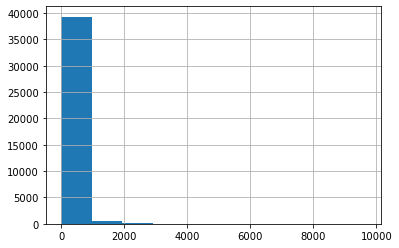

In [62]:
df.reviews_count.hist()

По графику видно, что по подпавляющему числу ресотранов (почти $40,000$), количество обзоров не больше $1000$. При этом есть какое-то очень малое число ресторанов, у которых обзоров от $4000$.

<AxesSubplot:>

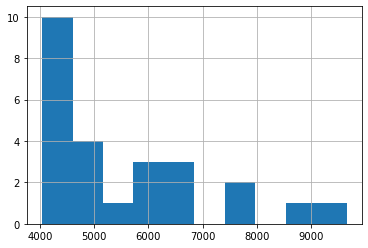

In [63]:
# количество ресторанов с числом обзоров больше 4000
df[df.reviews_count > 4000].reviews_count.hist()

Видно, что в основном число обзоров для каждого ресторана меньше ста. По нескольким ресторанам (1-4) 

-------------------
# 3. Обучение модели и проверка

In [64]:
RANDOM_SEED = 42

In [65]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
X = df.drop(['id',
             'rating', 'city',
             'cuisine',
             'reviews',
             'url_ta',
             'id_ta'],
            axis = 1)

y = df['rating']
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
    # Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [66]:
X.head(3)

,ranking,price_range,reviews_count,$,$$ - $$$,$$$$,Amsterdam,Athens,Barcelona,Berlin,...,vietnamese,wine bar,rev_1,rev_2,date_1,date_2,weekday_1,weekday_2,time_delta,time_proportion
0,5570.0,0.5,194.0,0,1,0,0,0,0,0,...,0,0,26,23,15146784,15111360,6,0,35424,0.997661
1,1537.0,0.5,10.0,0,1,0,0,0,0,0,...,0,0,14,23,14992992,14662944,3,6,330048,0.977987
2,353.0,0.9,688.0,0,0,1,0,0,0,0,...,0,0,21,15,15153696,15151968,0,5,1728,0.999886


In [67]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100,
                             random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [68]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21424900000000002


In [69]:
pd.DataFrame(y_pred.T)

,0
0,4.420
1,4.885
2,4.275
3,3.325
4,3.945
...,...
9995,4.425
9996,3.185
9997,4.320
9998,4.670
